In [1]:
import librosa
audio_path = 'Black_Footed_Albatross_0016_796067_9.mp3'
x , sr = librosa.load(audio_path)
print(type(x), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [2]:
import IPython.display as ipd
ipd.Audio(audio_path)

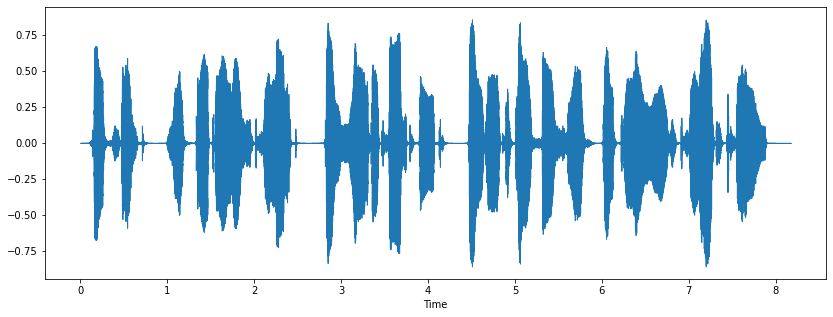

In [3]:
#display waveform
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)

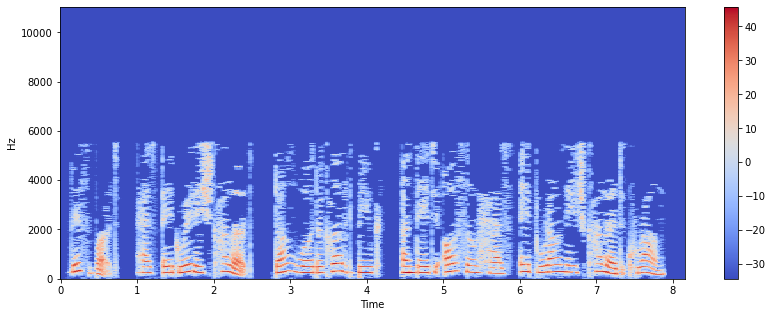

In [4]:
#display Spectrogram
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
#If to pring log of frequencies  
#librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

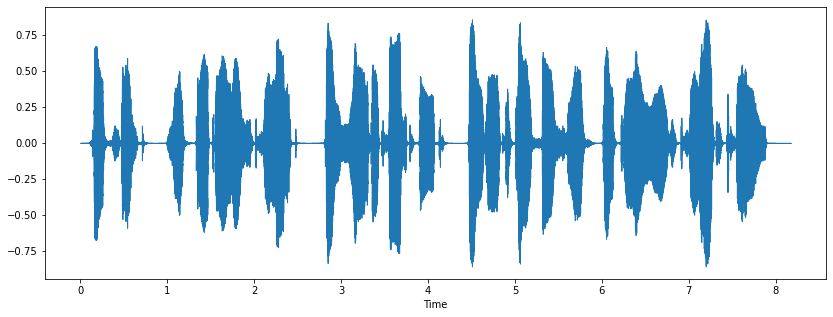

In [5]:
x, sr = librosa.load(audio_path)
#Plot the signal:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)

 

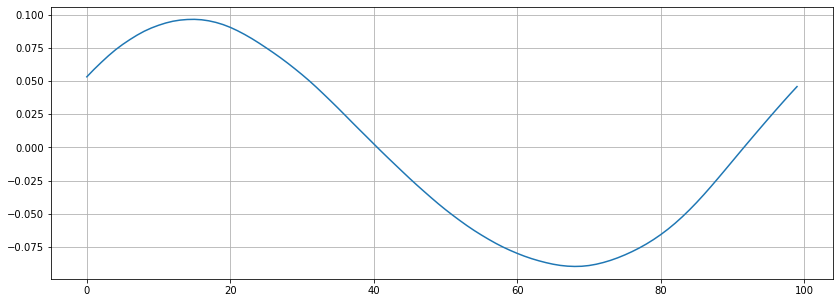

In [6]:
# Zooming in
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()

C:\Users\ivc21262adm\AppData\Local\Temp\ipykernel_16136\819940035.py:3: FutureWarning: Pass y=[ 1.0728358e-13 -6.2670491e-13 -1.1570248e-12 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]


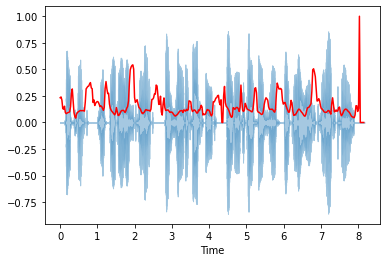

In [7]:
#spectral centroid -- centre of mass -- weighted mean of the frequencies present in the sound
import sklearn
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroids.shape
# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
#Plotting the Spectral Centroid along the waveform
librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

(20, 352)


C:\Users\ivc21262adm\AppData\Local\Temp\ipykernel_16136\1745963525.py:1: FutureWarning: Pass y=[ 1.0728358e-13 -6.2670491e-13 -1.1570248e-12 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(x, sr=sr)


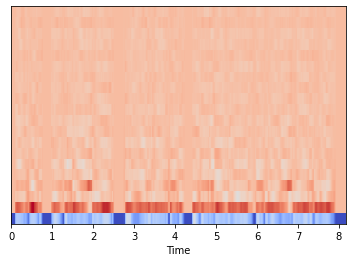

In [8]:
mfccs = librosa.feature.mfcc(x, sr=sr)
print(mfccs.shape)
#Displaying  the MFCCs:
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

In [9]:
#FEATURE for Audio
#Zero Crossing Rate
#Zooming in 
#Spectral Centroid
#MFCC — Mel-Frequency Cepstral Coefficients

C:\Users\ivc21262adm\AppData\Local\Temp\ipykernel_16136\860949266.py:2: FutureWarning: Pass y=[ 1.0728358e-13 -6.2670491e-13 -1.1570248e-12 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  poly_features=librosa.feature.poly_features(x) #order 1 by default


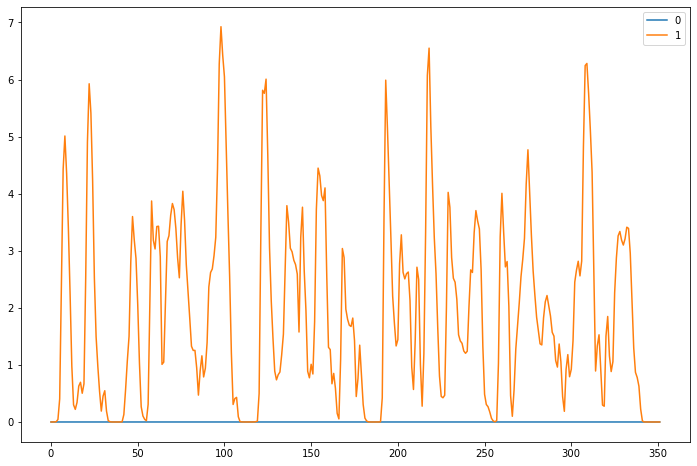

In [10]:
#The polyfeatures returns the coefficients of fitting an nth-order polynomial to the columns of a spectrogram
poly_features=librosa.feature.poly_features(x) #order 1 by default


plt.figure(figsize=(12,8))
plt.plot(poly_features[0], label="0")
plt.plot(poly_features[1], label="1")
plt.legend()
plt.show()

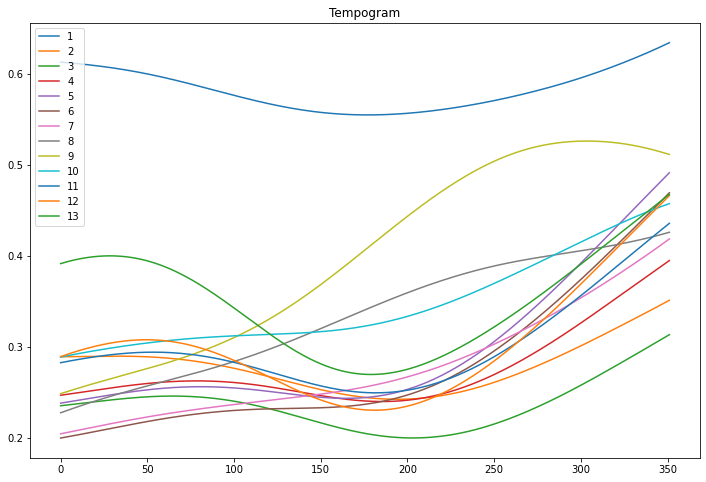

In [11]:
#The tempo, measured in Beats Per Minute (BPM)
hop_length = 512
oenv = librosa.onset.onset_strength(y=x, sr=sr, hop_length=hop_length)
tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr, hop_length=hop_length)

plt.figure(figsize=(12,8))
for i in range(1,14):
    plt.plot(tempogram[i], label=i)
plt.legend()
plt.title("Tempogram")
plt.show()

In [12]:
import time 
import logging 
import os 
import numpy as np
import torch
import torchvision
from torch import nn
import torch.nn.functional as F 
from torch.utils.data  import Dataset, DataLoader
import torch.distributed as dist
from tensorboardX import SummaryWriter
from collections import OrderedDict
import os.path as osp
from copy import deepcopy



def load_checkpoint(model,
                    filename,
                    map_location=None,
                    strict=False):
    """Load checkpoint from a file or URI.
    Args:
        model (Module): Module to load checkpoint.
        filename (str): Either a filepath or URL or modelzoo://xxxxxxx.
        map_location (str): Same as :func:`torch.load`.
        strict (bool): Whether to allow different params for the model and
            checkpoint.
        logger (:mod:`logging.Logger` or None): The logger for error message.
    Returns:
        dict or OrderedDict: The loaded checkpoint.
    """
    # load checkpoint from modelzoo or file or url
    
    if not osp.isfile(filename):
        raise IOError('{} is not a checkpoint file'.format(filename))
    checkpoint = torch.load(filename, map_location=map_location)
    # get state_dict from checkpoint
    if isinstance(checkpoint, OrderedDict):
        state_dict = checkpoint
    elif isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
    else:
        raise RuntimeError(
            'No state_dict found in checkpoint file {}'.format(filename))
    # strip prefix of state_dict
    if list(state_dict.keys())[0].startswith('module.'):
        state_dict = {k[7:]: v for k, v in state_dict.items()}
    # load state_dict
    if hasattr(model, 'module'):
        model.module.load_state_dict(state_dict, strict)
    else:
        model.load_state_dict(state_dict, strict)
    return checkpoint


def weights_to_cpu(state_dict):
    """Copy a model state_dict to cpu.
    Args:
        state_dict (OrderedDict): Model weights on GPU.
    Returns:
        OrderedDict: Model weights on GPU.
    """
    state_dict_cpu = OrderedDict()
    for key, val in state_dict.items():
        state_dict_cpu[key] = val.cpu()
    return state_dict_cpu


def save_checkpoint(model, filename, optimizer=None, meta=None):
    """Save checkpoint to file.
    The checkpoint will have 3 fields: ``meta``, ``state_dict`` and
    ``optimizer``. By default ``meta`` will contain version and time info.
    Args:
        model (Module): Module whose params are to be saved.
        filename (str): Checkpoint filename.
        optimizer (:obj:`Optimizer`, optional): Optimizer to be saved.
        meta (dict, optional): Metadata to be saved in checkpoint.
    """
    if meta is None:
        meta = {}
    elif not isinstance(meta, dict):
        raise TypeError('meta must be a dict or None, but got {}'.format(
            type(meta)))

    os.makedirs(osp.dirname(filename), exist_ok=True)
    if hasattr(model, 'module'):
        model = model.module

    checkpoint = {
        'meta': meta,
        'state_dict': weights_to_cpu(model.state_dict())
    }
    if optimizer is not None:
        checkpoint['optimizer'] = optimizer.state_dict()

    torch.save(checkpoint, filename)

class RunningAverage(object):
    def __init__(self):
        self.val_hist = {}
        self.n_hist = {}

    def update(self, data:dict, count:dict):
        assert(isinstance(data, dict))
        assert(isinstance(count, dict))
        for key, value in data.items():
            self.val_hist[key] = self.val_hist.get(key, [])+[value]
            self.n_hist[key] = self.n_hist.get(key, [])+[count[key]]

    def clear(self):
        self.val_hist = {}
        self.n_hist = {}

    def average(self):
        avg = {}
        for key, value in self.val_hist.items():
            n = np.array(self.n_hist[key])
            v = np.array(value)
            avg[key] = (n*v).sum()/float(n.sum())
        return avg

class IncrementalAverage(object):
    def __init__(self, gamma=0.1):
        self.data = {}
        self.gamma = gamma

    def update(self, data:dict):
        assert(isinstance(data, dict))
        for key, value in data.items():
            value_base = self.data.get(key, value)
            self.data[key] = value_base + value*self.gamma

    def get_value(self)->dict:
        return self.data



from abc import ABCMeta, abstractmethod
class BaseTrainer(object):
    __metaclass__=ABCMeta
    def __init__(self):
        pass
    @abstractmethod
    def train_once(self):
        pass
    @abstractmethod
    def eval_once(self):
        pass
    @abstractmethod
    def run(self):
        pass
    @property
    def timestamp(self):
        return time.strftime('%Y%m%d_%H%M%S', time.localtime())

    def get_dist_info(self): # copy from mmcv
        if torch.__version__ < '1.0':
            initialized = dist._initialized
        else:
            initialized = dist.is_initialized()
        if initialized:
            rank = dist.get_rank()
            world_size = dist.get_world_size()
        else:
            rank = 0
            world_size = 1
        return rank, world_size

class ClassifierTrainer(BaseTrainer):
    def __init__(self, model:nn.Module, train_dataloader:DataLoader, 
        optimizer, loss_func, batch_process, output_dir:str, local_rank:int, 
        val_dataloader:DataLoader=None, logger:logging.Logger=None, 
        writer:SummaryWriter=None, lr_scheduler=None, test_func=None,
        eval_every=5, print_every=50, resume_from=None, write_var_every=100, write_img_every=500,
        eval_hook=None, no_dist=False, batch_param={}):
        super(ClassifierTrainer, self).__init__()
        self.model = model
        self.train_dataloader, self.val_dataloader = train_dataloader, val_dataloader
        self.optimizer, self.loss_func = optimizer, loss_func
        self.batch_process = batch_process
        self.test_func = test_func
        self.output_dir = output_dir
        self.local_rank = local_rank
        self.lr_scheduler, self.eval_every = lr_scheduler, eval_every
        self.print_every = print_every
        self.rank, self.world_size = self.get_dist_info()
        self.train_iteration = len(train_dataloader)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir, exist_ok=True)
        if logger is None:
            self.logger = self.init_logger(output_dir, level=logging.INFO if self.local_rank==0 else logging.WARNING)
        else:
            self.logger = logger
        self.writer = writer if local_rank == 0 else None
        self.write_var_every = write_var_every
        self.write_img_every = write_img_every
        self.start_epoch = 0
        self.iteration_idx = int(0)
        self.eval_iteration_idx = int(0)
        self.eval_hook = eval_hook
        self.no_dist = no_dist
        self.batch_param = batch_param
        if resume_from is not None and len(resume_from)>0:
            self.model, self.optimizer, self.start_epoch = self.resume_model(self.model, self.optimizer, resume_from, self.logger)
            self.iteration_idx = len(self.train_dataloader)*self.start_epoch
            self.eval_iteration_idx = len(self.val_dataloader)*self.start_epoch
    @staticmethod
    def resume_model(model, optimizer, path, logger=None):
        checkpoint = load_checkpoint(model, path)
        if logger is not None:
            logger.info("resume model from:{}".format(path))
        start_epoch = 0
        if 'epoch' in checkpoint.get('meta', {}).keys():
            start_epoch = checkpoint['meta']['epoch']
        if 'optimizer' in checkpoint.keys():
            optimizer.load_state_dict(checkpoint['optimizer'])
        return model, optimizer, start_epoch

    def init_logger(self, log_dir=None, level=logging.INFO):
        for handler in logging.root.handlers[:]:
            logging.root.removeHandler(handler)
        logging.basicConfig(
            format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)
        logger = logging.getLogger(self.timestamp)
        logger.setLevel(level)
        if log_dir and self.rank == 0:
            log_file = os.path.join(log_dir, '{}.log'.format(self.timestamp))
            filehander = logging.FileHandler(log_file)
            logger.addHandler(filehander)
        return logger

    def process_batch_rtn(self, rtn, iter_idx, iter_all, epoch_idx, epoch, running_averager=None,  train_mode=True):
        mode = 'train' if train_mode else 'eval '
        mode_iter = self.iteration_idx if train_mode else self.eval_iteration_idx
        if 'output' in rtn.keys():
            if mode_iter % self.print_every == 0:
                self.logger.info("epoch: {:0>4d}/{:0>4d} [{:0>5d}/{:d}], mode:{}, {}".format(
                    epoch_idx, epoch, iter_idx, iter_all, mode, rtn['output']
                    ))
                print("epoch: {:0>4d}/{:0>4d} [{:0>5d}/{:d}], mode:{}, {}".format(
                    epoch_idx, epoch, iter_idx, iter_all, mode, rtn['output']
                    ))
        if 'vars' in rtn.keys() and 'count' in rtn.keys():
            if running_averager is not None:
                running_averager.update(rtn['vars'], rtn['count'])
            if self.writer is not None and  mode_iter % self.write_var_every == 0:
                self.writer.add_scalars("loss", rtn['vars'], mode_iter)
        if self.writer is not None and 'image' in rtn.keys():
            if mode_iter % self.write_img_every == 0:
                for tag, tensor in rtn['image'].items():
                    self.writer.add_image(tag, torchvision.utils.make_grid(tensor, normalize=True), mode_iter)

    def train_once(self, epoch_idx, epoch):
        self.model.train()
        running_averager = RunningAverage()
        
        iter_all = len(self.train_dataloader)
         
        for iter_idx, data in enumerate(self.train_dataloader):
            
            rtn = self.batch_process(self.model, data, train_mode=True, 
                optimizer=self.optimizer, loss_func=self.loss_func, **self.batch_param)
            assert(isinstance(rtn, dict))
            self.process_batch_rtn(rtn, iter_idx, iter_all, epoch_idx, epoch, running_averager, train_mode=True)
            self.iteration_idx += 1
        self.logger.info("epoch: {:0>4d}, mode:train, lr: {:.4f}, {}".format(
                    epoch_idx, 
                    list(self.optimizer.param_groups)[0]['lr'], 
                    str(running_averager.average())[1:-2]
                    ))
        print("epoch: {:0>4d}, mode:train, lr: {:.4f}, {}".format(
                    epoch_idx, 
                    list(self.optimizer.param_groups)[0]['lr'], 
                    str(running_averager.average())[1:-2]
                    ))
            
    def eval_once(self, epoch_idx, epoch):
        self.model.eval()
        running_averager = RunningAverage()
        iter_all = len(self.val_dataloader)
        for iter_idx, data in enumerate(self.val_dataloader):
            rtn = self.batch_process(self.model, data, train_mode=False, 
                loss_func=self.loss_func, **self.batch_param)
            assert(isinstance(rtn, dict))
            self.process_batch_rtn(rtn, iter_idx, iter_all, epoch_idx, epoch, running_averager, train_mode=False)
            self.eval_iteration_idx += 1
        self.logger.info("epoch: {:0>4d} mode: eval, {}".format(
                        epoch_idx, str(running_averager.average())[1:-2]
                        ))
        print("epoch: {:0>4d} mode: eval, {}".format(
                        epoch_idx, str(running_averager.average())[1:-2]
                        ))
        return running_averager.average()

    def run(self, epoch, start=None):
        self.logger.info("start training...")
        self.logger.info("output dir: {}".format(self.output_dir))
        print("start training...")
        print("output dir: {}".format(self.output_dir))
        start = self.start_epoch if start is None else start
        for epoch_idx in range(start, epoch):
            
            self.train_once(epoch_idx, epoch)
            if (epoch_idx % self.eval_every == 0 or epoch_idx == epoch-1):
                eval_rtn = {}
                test_rtn = {}
                if self.val_dataloader is not None:
                    eval_rtn = self.eval_once(epoch_idx, epoch)
                if self.test_func is not None:
                    test_rtn = self.test_func(self.model, self.val_dataloader, self.logger, self.writer, epoch_idx, **self.batch_param)
                if self.local_rank == 0 and self.eval_hook is not None:
                    self.eval_hook(self.model, epoch_idx, self.output_dir, eval_rtn, test_rtn, self.logger, self.writer)
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
        time.sleep(1)
        self.logger.info("training end!")
        print("training end!")
    


In [13]:
import torch.nn as nn
import torch
import math
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
import torch.nn.functional as F 
from functools import partial

def conv_layer_2d(in_channel, out_channel, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size, stride, padding, bias=False),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace=True)
    )

class CNNRNN(nn.Module):
    def __init__(self, n_filters, embedding_dim=1024, drop_prob=0.5,
                 nhidden=1024, rnn_layers=1, bidirectional=False, nsent=1024,):
        super(CNNRNN, self).__init__()
        self.bidirectional = bidirectional
        self.num_direction = 2 if bidirectional else 1
        self.embedding_dim = embedding_dim
        self.nhidden = nhidden // self.num_direction
        self.rnn_layers = rnn_layers
        self.drop_prob = drop_prob
        self.nsent = nsent // self.num_direction
        
        self.Conv = nn.Sequential(
            nn.BatchNorm2d(1),
            conv_layer_2d(1, 64, (n_filters, 1), (1,1), (0,0)), # 2048
            conv_layer_2d(64, 64, (1,3), (1,1), (0,1)), # 2048
            nn.MaxPool2d(kernel_size=(1,3), stride=(1,2), padding=(0,1)), # 1024
            conv_layer_2d(64, 128, (1,17), (1,2), (0,8)), # 512
            conv_layer_2d(128, 256, (1,13), (1,2), (0,6)), # 256
            conv_layer_2d(256, 256, (1,3), (1,1), (0,1)), # 256
            conv_layer_2d(256, 512, (1,9), (1,2), (0,4)), # 128
            nn.MaxPool2d(kernel_size=(1,3), stride=(1,2), padding=(0,1)), # 64
            conv_layer_2d(512, 512, (1,3), (1,1), (0,1)), # 64
            conv_layer_2d(512, 1024, (1,5), (1,2), (0,2)) # 32
        )
        self.RNN = nn.LSTM(
            self.embedding_dim, self.nhidden, num_layers=self.rnn_layers, batch_first=True, bidirectional=self.bidirectional, dropout=self.drop_prob
            )
         

        self.apply(self.weights_init)

    def init_hidden(self, x, n_dim):
        batch_size = x.shape[0]
        rtn = (torch.zeros(self.num_direction, batch_size, n_dim, device=x.device).requires_grad_(),
                torch.zeros(self.num_direction, batch_size, n_dim, device=x.device).requires_grad_())
        return rtn
        
    @staticmethod
    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            m.weight.data.normal_(0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)
        elif classname.find('Linear') != -1:
            m.weight.data.normal_(0.0, 0.02)
            if m.bias is not None:
                m.bias.data.fill_(0.0)

    def extract_feature(self, x, lens):
        words_emb, sent_emb = self.forward(x, lens)
        return sent_emb

    def forward(self, x, cap_lens):
        # (batch, channel, 40, 2048)
        # print(x.shape, x.device, next(self.parameters()).device)
        if x.dim() == 3:
            x = x.unsqueeze(1)
        #print("before BN: shape: {}".format(x.shape))
        # print("before Conv: shape: {}".format(x.shape))
        x = self.Conv(x).squeeze()
        # print("after Conv: shape: {}".format(x.shape))
        x = x.transpose(1,2)
        cap_lens = (cap_lens).cpu().data.tolist()
        if isinstance(cap_lens, int):
            cap_lens = [cap_lens]
        batch_size, length = x.shape[:2]
        output = x

        h0 = self.init_hidden(x, self.nhidden)
        x = pack_padded_sequence(x, cap_lens, batch_first=True)
        output, hidden = self.RNN(x, h0)
        output = pad_packed_sequence(output, batch_first=True, total_length=length)[0]
        #print(output.shape)
        output = output.view(batch_size, length, self.rnn_layers, self.num_direction*self.nhidden)[:,:,-1,:]
        
        words_emb = output.transpose(1, 2)
        sent_emb = output.mean(-2) # hidden[0].transpose(0, 1).contiguous()
        sent_emb = sent_emb.view(-1, self.nsent * self.num_direction)
        # print(words_emb.shape, sent_emb.shape)
        # print(output.shape)
        return words_emb, sent_emb



In [14]:
import torch
import torch.nn as nn 

class JointEmbeddingLossLayer(nn.Module):
    def __init__(self, loss_diff_coeff, loss_same_coeff):
        super(JointEmbeddingLossLayer, self).__init__()
        self.loss_diff_coeff = loss_diff_coeff
        self.loss_same_coeff = loss_same_coeff
    
    def forward(self, fea_txt, fea_img, label):
        loss, grad, accu = JointEmbeddingLoss(
            fea_txt, fea_img, label, self.loss_diff_coeff, self.loss_same_coeff
            )
        return {'loss':loss, 'grad':grad, 'accu':accu}

        
def JointEmbeddingLoss(fea_txt, fea_img, label, loss_diff_coeff, loss_same_coeff):
    batchsize = fea_img.size(0)
    num_class = fea_txt.size(0)
    score = torch.zeros(batchsize, num_class)
    txt_grads = torch.zeros_like(fea_txt, requires_grad=True)
    img_grads = torch.zeros_like(fea_img, requires_grad=True)

    #score = torch.mm(fea_txt.cpu(), fea_img.cpu().transpose(0,1))
    score = torch.mm(fea_img, fea_txt.transpose(0,1))

    score_abs = score - score.diag()
    selected_idx_diff = (label.unsqueeze(0).repeat([batchsize, 1])!=label.unsqueeze(1))
    selected_idx_same = (label.unsqueeze(0).repeat([batchsize, 1])==label.unsqueeze(1))
    loss_diff = score_abs[selected_idx_diff]+1
    loss_same = score_abs[selected_idx_same]
    # print(score.detach().tolist())

    loss = (loss_diff_coeff * loss_diff[loss_diff>0].sum()+ loss_same_coeff * loss_same[loss_same>0].sum())
    # loss = loss_diff[loss_diff>0].sum()

    _, max_idx = score.max(dim=1)
    acc_batch = (max_idx==torch.LongTensor(range(score.shape[1])).to(max_idx.device)).sum().cpu().item()

    acc_batch = 100 * (acc_batch / batchsize)
    denom = batchsize * num_class

    return loss/denom, [txt_grads/denom, img_grads/denom], acc_batch


In [15]:
from __future__ import print_function
import sys
import os
import time
import logging
import re
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import h5py


#---------------------------for image----------------------------#
def check_dir(dir_name):
    if not os.path.isdir(dir_name):
        os.makedirs(dir_name)

def read_list_file(file_name):
    with open(file_name, 'rb') as fp:
        content = fp.readlines()
    content = [data.strip().decode('utf8') for data in content]
    content = [data.replace(u"\uFFFD", " ") for data in content]
    content = [data.replace("  ", " ") for data in content]
        #content = fp.read().decode("utf8").split("\n")
    return content  #[x.strip() for x in content]  #delete space and \n

def read_dict_file(file_name):
    with open(file_name, 'rb') as fp:
        content = fp.readlines()
    dict_content = [x.strip().decode("utf8").split() for x in content]
    dict_content = {key:value for [key, value] in dict_content}
    return dict_content

# return dict, {class_id:class name}
def read_class_name(class_file_name):
    return read_dict_file(class_file_name)

# return a dict, {image_id:class_id}
def read_images_class_label(label_file_name):
    return read_dict_file(label_file_name)

def read_images_filename(image_list_filename):
    return read_dict_file(image_list_filename)

# return a list
def read_class_ids(filename):
    ids = read_list_file(filename)
    pattern = r"\b0*([1-9][0-9]*|0)"
    ids = [re.sub(pattern, r"\1", id) for id in ids]
    return ids

def read_bbox(filename):
    """read the bbox file
    return a dict:{ID:int tuple}
    """
    bbox = read_list_file(filename)
    pattern = re.compile(r"(\d+) (\d+.\d*) (\d+.\d*) (\d+.\d*) (\d+.\d*)")
    m_list = [pattern.match(bbox_line) for bbox_line in bbox]
    bbox_dict = {m.group(1):(float(m.group(2)), float(m.group(3)), float(m.group(4)), float(m.group(5))) for m in m_list}
    return bbox_dict 


# return a dict, length is the num of class, {class_id:filename_id_list}
def classify_images_by_class(class_dict, image_filename_dict, class_label_dict):
    class_filename_dict = { class_id:[] for class_id in class_dict.keys()}

    for (image_id, class_id) in class_label_dict.items():  #{image_id:class_id}
        class_filename_dict.get(class_id).append(image_filename_dict.get(image_id))
    return class_filename_dict

def classify_images_ids_by_class(class_dict, class_label_dict):
    class_filename_ids_dict = { class_id:[] for class_id in class_dict.keys()}

    for (image_id, class_id) in class_label_dict.items():  #{image_id:class_id}
        class_filename_ids_dict.get(class_id).append(image_id)
    return class_filename_ids_dict

def write_image_feature_h5(filename, data):
    with h5py.File(filename,'w') as fp:
        fp.create_dataset("image_feature", data=data)

def read_image_feature_h5(filename):
    with h5py.File(filename,'r') as fp:
        data = fp["image_feature"][:]
    return data

#----------------for text-------------------------#
def str2ascii(string_data):
    return [ord(s) for s in string_data]

def ascii2str(ascii_data):
    return [chr(a) for a in ascii_data]

def check_vocabulary(string_data, vocabulary):
    for c in string_data:
        if c not in vocabulary:
            vocabulary.append(c)
            print("add vocabulary:{}, from \"{}\"".format(c, string_data))

#data":[array, array]
def write_text_feature_h5(filename, data):
    fp = h5py.File(filename,'w')
    for idx in range(len(data)):
        fp.create_dataset(str(idx), data=data[idx])
    fp.close()

def read_text_feature_h5(filename):
    fp = h5py.File(filename,'r')
    data = []
    for idx in range(len(fp)):
        data.append(fp[str(idx)][:])
    fp.close()
    return data

def read_class_text_feature_h5(filename):
    with h5py.File(filename,'r') as fp:
        data = fp["text_feature"][:]
    return data
     
def write_class_text_feature_h5(filename, data):
    with h5py.File(filename,'w') as fp:
        data = fp.create_dataset("text_feature", data=data)


def read_text_idx_feature_h5(filename):
    with h5py.File(filename,'r') as fp:
        data = fp["text_idx_feature"][:]
    return data
     
def write_text_idx_feature_h5(filename, data):
    with h5py.File(filename,'w') as fp:
        data = fp.create_dataset("text_idx_feature", data=data)


def read_all_captions(filename):
    content = read_list_file(filename)
    captions = []
    for line in content:
        #line = line.replace("\ufffd", " ")
        string = line
        # clean data: reference: https://github.com/srviest/char-cnn-text-classification-pytorch/blob/master/data_loader_txt.py
        #string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
        #string = re.sub(r"\'s", " \'s", string)
        #string = re.sub(r"\'ve", " \'ve", string)
        #string = re.sub(r"n\'t", " n\'t", string)
        #string = re.sub(r"\'re", " \'re", string)
        #string = re.sub(r"\'d", " \'d", string)
        #string = re.sub(r"\'ll", " \'ll", string)
        #string = re.sub(r",", " , ", string)
        #string = re.sub(r"!", " ! ", string)
        #string = re.sub(r"\(", " \( ", string)
        #string = re.sub(r"\)", " \) ", string)
        #string = re.sub(r"\?", " \? ", string)
        string = re.sub(u"\ufffd", " ", string)
        string = re.sub(r"\s{2,}", " ", string)
        # clean data end
        line = string

        line = line.lower()
        if len(line)>0:
            captions.append(line)

    return captions

def read_text_vocabulary_json(text_feature_dir, default_flag=False):
    import json
    if default_flag:
        vocabulary_json_filename = os.path.join(text_feature_dir, "alphabet_default.json")
    else:
        vocabulary_json_filename = os.path.join(text_feature_dir, "alphabet.json")
    with open(vocabulary_json_filename, 'r') as f:
         vocabulary = json.load(f)
    return vocabulary

def write_text_vocabulary_json(text_feature_dir, vocabulary):
    import json
    vocabulary_json_filename = os.path.join(text_feature_dir, "alphabet.json")
    with open(vocabulary_json_filename, 'w') as f:
        json.dump(vocabulary, f)


def show_progress_bar(percentage):
    if percentage<0:
        print("show_progress_bar: parameter error")
        percentage = 0
    elif percentage>100:
        print("show_progress_bar: parameter error")
        percentage = 100
    percentage = int(percentage*100)

    s1 = "\r[{}{}]{}%".format(">"*percentage, " "*(100-percentage), percentage)
    if percentage==100:
        s1 += "\n"
    sys.stdout.write(s1)
    sys.stdout.flush()

def show_progress_bar_increment(inc, L=[]):
    if len(L)==0:
        L.append(0)
    L[0] += inc
    show_progress_bar(L[0])
    return L[0]


def convert_to_onehot(data, n_class):
    onehot = np.eye(n_class)[data.reshape(-1)]
    return onehot.reshape(list(data.shape)+[n_class])


def convert_one_sentence(text, vocabulary, target_len):
    # text_ascii = text.encode('ascii', 'ignore')
    text_ascii = str2ascii(text)
    text_idx_np = np.zeros((target_len,), dtype=np.int16)
    try:
        text_idx_np_temp = np.array([vocabulary.index(c)+1 for c in text])
        if text_idx_np_temp.shape[0]>target_len:
            text_idx_np_temp = text_idx_np_temp[:target_len]
        text_idx_np[:text_idx_np_temp.shape[0]] = text_idx_np_temp
    except ValueError:
        print("convert error: {}".format(text))
        # return None
    # text_onehot = convert_to_onehot(text_idx_np, len(vocabulary)+1)
    return text_idx_np  # text_onehot


def rename_by_order(full_name_src):
    if not os.path.exists(full_name_src):
        return full_name_src
    filename, ext = os.path.splitext(full_name_src)
    for idx in range(99999):
        full_name = filename+".{:05d}".format(idx)+ext
        if not os.path.exists(full_name):
            os.rename(src=full_name_src, dst=full_name)
            break
        else:
            continue
    return full_name

def get_ordered_name(full_name_base):
    filename, ext = os.path.splitext(full_name_base)
    for idx in range(99999):
        full_name = filename+"{:05d}".format(idx)+ext
        if not os.path.exists(full_name):
            os.path.isdir(full_name)
            os.makedirs(full_name)
            break
        else:
            continue
    return full_name



def sents2idx(sent_list, vocabulary, max_length=201):
    """
    return: array, (max_length, len_sent)
    """
    captions = sent_list
    #convert to ascii
    captions_ascii = [str2ascii(string_data) for string_data in captions]
    #save to h5 file
    captions_ascii_np = [np.array(caption_ascii) for caption_ascii in captions_ascii]
    #save idx to file
    captions_idx_np = np.zeros((max_length, len(captions_ascii_np)), dtype=np.int16)
    for idx in range(len(captions_ascii_np)):
        caption_idx_np = np.array([vocabulary.index(c)+1 for c in ascii2str(captions_ascii_np[idx])])
        if caption_idx_np.shape[0]>max_length:
            print("[text feature]: warning: clip the data")
            caption_idx_np = caption_idx_np[0:max_length]
        captions_idx_np[0:caption_idx_np.shape[0], idx] = caption_idx_np
    return captions_ascii_np, captions_idx_np


import pickle
def read_pickle(filepath, encoding="utf8"):
    with open(filepath, "rb") as fp:
        data = pickle.load(fp, encoding=encoding)
    return data


import scipy
import librosa

def preemphasis(signal,coeff=0.97):
    """perform preemphasis on the input signal.
    
    :param signal: The signal to filter.
    :param coeff: The preemphasis coefficient. 0 is none, default 0.97.
    :returns: the filtered signal.
    """    
    return np.append(signal[0],signal[1:]-coeff*signal[:-1])


def load_one_audio_file(path, audio_conf, windows={'hamming': scipy.signal.hamming,
        'hann': scipy.signal.hann, 'blackman': scipy.signal.blackman,
           'bartlett': scipy.signal.bartlett}):
    audio_type = audio_conf.get('audio_type', 'melspectrogram')
    if audio_type not in ['melspectrogram', 'spectrogram']:
        raise ValueError('Invalid audio_type specified in audio_conf. Must be one of [melspectrogram, spectrogram]')
    preemph_coef = audio_conf.get('preemph_coef', 0.97)
    sample_rate = audio_conf.get('sample_rate', 16000)
    window_size = audio_conf.get('window_size', 0.025)
    window_stride = audio_conf.get('window_stride', 0.01)
    window_type = audio_conf.get('window_type', 'hamming')
    num_mel_bins = audio_conf.get('num_mel_bins', 40)
    target_length = audio_conf.get('target_length', 2048)
    use_raw_length = audio_conf.get('use_raw_length', False)
    padval = audio_conf.get('padval', 0)
    fmin = audio_conf.get('fmin', 20)
    n_fft = audio_conf.get('n_fft', int(sample_rate * window_size))
    win_length = int(sample_rate * window_size)
    hop_length = int(sample_rate * window_stride)
    # load audio, subtract DC, preemphasis
    # print("load audio file:{}".format(path))
    y, sr = librosa.load(path, sample_rate)
    if y.size == 0:
        y = np.zeros(200)
    y = y - y.mean()
    y = preemphasis(y, preemph_coef)
    # compute mel spectrogram
    stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length,
        win_length=win_length,
        window=windows.get(window_type, windows['hamming']))
    spec = np.abs(stft)**2
    if audio_type == 'melspectrogram':
        mel_basis = librosa.filters.mel(sr, n_fft, n_mels=num_mel_bins, fmin=fmin)
        melspec = np.dot(mel_basis, spec)
        logspec = librosa.power_to_db(melspec, ref=np.max)
    elif audio_type == 'spectrogram':
        logspec = librosa.power_to_db(spec, ref=np.max)
    n_frames = logspec.shape[1]
    if use_raw_length:
        target_length = n_frames
    p = target_length - n_frames
    if p > 0:
        logspec = np.pad(logspec, ((0,0),(0,p)), 'constant',
            constant_values=(padval, padval))
    elif p < 0:
        logspec = logspec[:,0:p]
        n_frames = target_length

    return logspec, n_frames

In [16]:
"""baseline model
1. Deep Cross-Modal Audio-Visual Generation
2. CMCGAN: A Uniform Framework for Cross-Modal Visual-Audio Mutual Generation
"""
import os
import h5py
import argparse
import logging
import time
import tqdm
import json
import pickle
import random
import numpy as np 

import torch
from tensorboardX import SummaryWriter
from torch import nn
import torch.nn.functional as F 
from torch.utils.data  import Dataset, DataLoader
import torch.distributed as dist


torch.manual_seed(1234)
random.seed(1234)
np.random.seed(1234)

class DatasetBase(Dataset):
    def __init__(self):
        pass

    @staticmethod
    def encode_text(text):
        alphabet = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "-", ",", ";", ".", "!", "?", ":", "'", "\"", "\\", "/", "|", "_", "@", "#", "$", "%", "^", "&", "*", "~", "`", "+", "-", "=", "<", ">", "(", ")", "[", "]", "{", "}", "\n", " "]
        text_idx = convert_one_sentence(text, alphabet, target_len=201)
        text_onehot = convert_to_onehot(data=text_idx-1, n_class=len(alphabet))
        return text_onehot
    
    @staticmethod
    def get_rand(feature):
        # feature: (10, 1024)
        rand_idx = random.randint(0, len(feature)-1)
        return feature[rand_idx], rand_idx

# class PlaceSubSet(DatasetBase):
#     class_label = {
#         'bedroom':0, 'dinette':1, 'dining_room':2, 'home_office':3, 'hotel_room':4,
#         'kitchenette':5, 'living_room':6
#     }
#     def __init__(self, data_root, train=True):
#         # read meta data
#         split = "train" if train else "test"
#         self.json_data = json.load(open(os.path.join(data_root, "{}.json".format(split)), "r"))
#         self.image_folder = self.json_data['image_base_path']
#         self.audio_folder = self.json_data['audio_base_path']
#         # load image embedding
#         image_feature_path = self.json_data['image_feature_path']
#         self.image_embedding = pickle.load(open(image_feature_path, mode='rb'), encoding='latin1')
#         print("load image feature from: {}".format(image_feature_path))
#         self.data = self.json_data['data']
    
#     def __len__(self):
#         return len(self.data)
    
#     def __getitem__(self, index):
#         json_data = self.data[index]
#         image_path = json_data["image"][2:]
#         audio_path = json_data['wav'][5:]
#         audio_data, audio_len = load_one_audio_file(
#             os.path.join(self.audio_folder, audio_path), 
#             {"target_length":2048}
#             )
#         audio_data=audio_data/np.max(np.abs(audio_data)) # norm the data
#         rand_idx_image = random.randint(0, 9)
#         image_data = self.image_embedding[index][rand_idx_image]
#         text = json_data["asr_text"].strip()
#         text_onehot = self.encode_text(text)
#         text_len = len(text)
#         label = self.class_label[image_path.split("/")[0]]
#         return image_data, audio_data, audio_len, text_onehot, \
#             text_len, label


# class FlowerDataset(DatasetBase):
#     def __init__(self, data_root, train=True):
#         split = "train" if train else "test"
#         self.json_data_all = json.load(open(os.path.join(data_root, "./{}.json".format(split)), "r"))
#         image_embedding_path = self.json_data_all["image_feature_path"]
#         print("load image embedding from:", image_embedding_path)
#         self.image_embedding = pickle.load(open(image_embedding_path, "rb"))
#         self.audio_folder = self.json_data_all["audio_base_path"]
#         self.data = self.json_data_all['data']
    
#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, index):
#         data = self.data[index]
#         image_data, _ = self.get_rand(self.image_embedding[index])
        
#         while True:
#             try:
#                 text, rand_idx = self.get_rand(data['text'])
#                 text_onehot = self.encode_text(text)
#                 audio_data_path = os.path.join(self.audio_folder, data['wav'][rand_idx])
#                 audio_data, audio_len = load_one_audio_file(audio_data_path, {"target_length":2048})
#                 if audio_len >= 64:
#                     break
#                 else:
#                     continue
#             except EOFError:
#                 print("data not found: {}".format(audio_data_path))
#                 continue
#         text_len = len(text)
#         label = int(data['class'])-1
#         return image_data, audio_data, audio_len, text_onehot, text_len, label 


class BirdDataset(DatasetBase):
    def __init__(self, data_root, train=True):
        split = "train" if train else "test"
       # self.json_data_all = json.load(open(os.path.join(data_root, "./{}.json".format(split)), 'r'))
        self.json_data_all = json.load(open(os.path.join(data_root, r"./{}.json".format(split)), 'r'))
        image_embedding_path = self.json_data_all['image_feature_path']
        print("load image embedding from:", image_embedding_path)
        self.image_embedding = pickle.load(open(image_embedding_path, 'rb'))
        self.audio_folder = self.json_data_all['audio_base_path']
        self.data = self.json_data_all['data']
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        data = self.data[index]
        image_data, _ = self.get_rand(self.image_embedding[index])
        
        while True:
            try:
                text, rand_idx = self.get_rand(data['text'])
                text_onehot = self.encode_text(text)
                audio_data_path = os.path.join(self.audio_folder, data['audio'][rand_idx])
                audio_data, audio_len = load_one_audio_file(audio_data_path, {"target_length":2048})
                if audio_len >= 64:
                    break
                else:
                    continue
            except EOFError:
                print("data not found: {}".format(audio_data_path))
                continue
        text_len = len(text)
        label = int(data['class'].split('.')[0])-1
        return image_data, audio_data, audio_len, text_onehot, text_len, label


def sort_torch_data(tuple_data:tuple, sort_idx:int)->tuple:
    sorted_cap_lens, sorted_cap_indices = \
        torch.sort(tuple_data[sort_idx], 0, True)
    rtn_data = tuple([d[sorted_cap_indices] for d in tuple_data])
    return rtn_data

grads = {}
def save_grad(name):
    def hook(grad):
        grads[name] = grad.abs().mean()
    return hook

def batch_process(model, data, train_mode=True, **kwargs)->dict:
    image_feature, audio_data, n_frames, text_onehot, text_len, label = data
#    image_feature, audio_data, label = image_feature.float().cuda(), audio_data.float().cuda(), label.long().cuda()
    image_feature, audio_data, label = image_feature.float(), audio_data.float(), label.long()
    if train_mode:
        # print(image_feature.shape, audio_data.shape)
        if kwargs.get('length_required', False):
            image_feature, audio_data, n_frames, text_onehot, text_len, label = \
                sort_torch_data((image_feature, audio_data, n_frames, text_onehot, text_len, label), sort_idx=2)
            _, sent_emb = model.forward(audio_data, n_frames//64)
            audio_feature = sent_emb
        else:
            audio_feature = model.forward(audio_data)
        # audio_feature = nn.Parameter(audio_feature)
        audio_feature.register_hook(save_grad('audio_feature'))
        optimizer = kwargs['optimizer']
        loss_func = kwargs['loss_func']
        loss = loss_func(audio_feature, image_feature, label)
        model.zero_grad()
        loss['loss'].backward()
        # grad_mean = audio_feature.grad.mean().item()
        optimizer.step()
        rtn = {
            "vars":{"loss":loss['loss'].item(), 'accu':loss['accu']}, 
            'count':{"loss":label.shape[0], 'accu':label.shape[0]}, 
            "output":"loss: {:.3f}({:.3f},{:.3f},{:.3f}), accu: {:.3f}, grad_mean:{:.7f}".format(
                loss['loss'].item(), loss['loss_jel'].item(), loss['loss_l1'].item(), 
                loss['loss_distill'].item(), loss['accu'], grads.get('audio_feature', 0)
                )
            }
    else:
        with torch.no_grad():
            if kwargs.get('length_required', False):
                image_feature, audio_data, n_frames, text_onehot, text_len, label = \
                    sort_torch_data((image_feature, audio_data, n_frames, text_onehot, text_len, label), sort_idx=2)
                _, sent_emb = model.forward(audio_data, n_frames//64)
                audio_feature = sent_emb
            else:
                audio_feature = model.forward(audio_data)
        loss_func = kwargs['loss_func']
        loss = loss_func(audio_feature.detach(), image_feature.detach(), label.detach())
        rtn = {
            "vars":{"loss":loss['loss'].item(), "accu":loss['accu']}, 
            'count':{"loss":label.shape[0], "accu":label.shape[0]},
            "output":"loss: {:.3f}({:.3f},{:.3f},{:.3f}), accu: {:.3f}".format(
                loss['loss'].item(), loss['loss_jel'].item(), loss['loss_l1'].item(), 
                loss['loss_distill'].item(), loss['accu']
                )
            }
    return rtn

@torch.no_grad()
class EvalClass(object):
    def __init__(self, recall_topk=50):
        self.recall_topk = 50
        self.best_accu = 0
        self.best_ap50 = 0
    @staticmethod
    def eval_class(query_feature_all, target_feature_all, label_all, topk):
        # query class center
        label_all_list = list(set(label_all))
        print("total eval class: {}".format(len(label_all_list)))
        label_all = np.array([label_all_list.index(label) for label in label_all])
        class_num = len(label_all_list)
        label_all_list = list(set(label_all))
        class_center_query = np.array([query_feature_all[label_all==label].mean(axis=0) for label in label_all_list])  # class_num x feature
    
        scores_all = np.matmul(target_feature_all, class_center_query.transpose()) # batch x class_num
        # scores_all = scores_all/np.expand_dims(abs(scores_all).sum(1), 1) # heart performance
        preds = scores_all.argmax(axis=1)  # batch
        accu_all = (preds==label_all).sum()/label_all.shape[0]
        topk_index_per_class = [np.argsort(scores_all[:,label], axis=0)[-topk:][::-1] for label in label_all_list]  # 50 x 50
        scores_per_class_50 = [scores_all[idx,:] for idx in topk_index_per_class]  #50 x 50
        labels_per_class_50 = [label_all[idx] for idx in topk_index_per_class] # 50 x 50
        # label_per_class_50 = [label[np.argsort(score)[-topk:][::-1]] for score,label in zip(scores_per_class, labels_per_class)]
        ap50 = np.array([(label==k).sum() for k, label  in enumerate(labels_per_class_50)]).sum()/np.array(labels_per_class_50).size
        # print(np.array(labels_per_class_50).size)
        return accu_all*100, ap50*100

    def __call__(self, model, val_dataloader, logger:logging.Logger, 
        writer:SummaryWriter, eval_iteration_idx, **kwargs):
        # extract feature
        audio_feature_all = []
        image_feature_all = []
        label_all = []
        for idx, data in enumerate(val_dataloader):
            image_feature, audio_data, n_frames, text_onehot, text_len, label = data
            #image_feature, audio_data, label = image_feature.float().cuda(), audio_data.float().cuda(), label.long().cuda()
            image_feature, audio_data, label = image_feature.float(), audio_data.float(), label.long()
            with torch.no_grad():
                if kwargs.get('length_required', False):
                    # sort data
                    image_feature, audio_data, n_frames, text_onehot, text_len, label = \
                        sort_torch_data((image_feature, audio_data, n_frames, text_onehot, text_len, label), sort_idx=2)
                    _, sent_emb = model.forward(audio_data, n_frames//64)
                    audio_feature = sent_emb
                else:
                    audio_feature = model.forward(audio_data)
            audio_feature_all.append(audio_feature.detach().cpu().numpy())
            image_feature_all.append(image_feature.detach().cpu().numpy())
            label_all.append(label.detach().cpu().numpy())
        audio_feature_all, image_feature_all, label_all = np.concatenate(audio_feature_all),\
            np.concatenate(image_feature_all), np.concatenate(label_all)
        accu, ap = self.eval_class(audio_feature_all, image_feature_all, label_all, self.recall_topk)

        if logger is not None:
            logger.info("mode: test, accu: {:.3f}, ap50: {:.3f}".format(accu, ap))
        print("mode: test, accu: {:.3f}, ap50: {:.3f}".format(accu, ap))
        rtn = {"accu":accu, 'ap50':ap}
        if writer is not None:
            writer.add_scalars("test", rtn, global_step=eval_iteration_idx)
        return rtn
        



class EvalHook(object):
    def __init__(self):
        self.best_accu = 0
        self.best_ap50 = 0
    
    def __call__(self, model:nn.Module, epoch_idx, output_dir, 
        eval_rtn:dict, test_rtn:dict, logger:logging.Logger, writer:SummaryWriter):
        # save model
        is_best = test_rtn.get('accu', 0) > self.best_accu
        self.best_accu = test_rtn.get('accu', 0) if is_best else self.best_accu
        self.best_ap50 = test_rtn.get('ap50', 0) if is_best else self.best_ap50
        model_filename = "epoch_{}.pth".format(epoch_idx)
        save_checkpoint(model, os.path.join(output_dir, model_filename), 
            meta={'epoch':epoch_idx})
        os.system(
            "ln -sf {} {}".format(os.path.abspath(os.path.join(output_dir, model_filename)), 
            os.path.join(output_dir, "latest.pth"))
            )
        if is_best:
            os.system(
            "ln -sf {} {}".format(os.path.abspath(os.path.join(output_dir, model_filename)), 
            os.path.join(output_dir, "best.pth"))
            )

        if logger is not None:
            logger.info("EvalHook: best accu: {:.3f}, best ap50: {:.3f}, is_best: {}".format(self.best_accu, self.best_ap50, is_best))

class LossFunc(object):
    def __init__(self, loss_diff, loss_same, jel_flag=True,
        l1_flag=True, lambda_l1=1, distill=True, distill_T=2, lambda_distill=1):
        if jel_flag:
            self.JEL = JointEmbeddingLossLayer(loss_diff_coeff=loss_diff, loss_same_coeff=loss_same)
        else:
            self.JEL = None
        if l1_flag:
            self.L1 = torch.nn.L1Loss()
        else:
            self.L1 = None
        self.lambda_l1 = lambda_l1
        if distill:
            self.distill = self.get_distill_loss
            self.distill_T = distill_T
        else:
            self.distill = None
        self.lambda_distill = lambda_distill

    def get_distill_loss(self, source, target):
        source, target = source, target.div(self.distill_T) # soft the target
        source, target = F.log_softmax(source, dim=1), F.softmax(target, dim=1)
        # loss = -(source*torch.log(target)).sum(dim=1).mean() *2*self.distill_T*self.distill_T
        loss = F.kl_div(source, target)
        return loss


    def __call__(self, source:torch.Tensor, target:torch.Tensor, label):
        if self.JEL is not None:
            jel = self.JEL(source, target, label)
        else:
            jel = {
                # 'loss':torch.cuda.FloatTensor([0]).requires_grad_(),
                # 'grad':torch.cuda.FloatTensor([0]),
                'loss': torch.FloatTensor([0]).requires_grad_(),
                'grad': torch.FloatTensor([0]),
                'accu':0
                }

        if self.L1 is not None:
            l1 = self.L1(source/torch.norm(source), target/torch.norm(target))
        else:
            #l1 = torch.cuda.FloatTensor([0]).requires_grad_()
            l1 = torch.FloatTensor([0]).requires_grad_()
        if self.distill is not None:
            distill = self.distill(source, target) # self.compute_mmd(source, target) #
        else:
            #distill = torch.cuda.FloatTensor([0]).requires_grad_()
            distill = torch.FloatTensor([0]).requires_grad_()
        jel.update(
            {
                'loss':jel['loss']+l1*self.lambda_l1+distill*self.lambda_distill,
                'loss_jel':jel['loss'],
                'loss_l1':l1,
                'loss_distill':distill
            }
        )
        return jel

import random
def eval_audio_feature(audio_feature_path, image_feature_path, filename_path, topk=50):
    def load_pickle(filename):
        with open(filename, "rb") as fp:
            data = pickle.load(fp)
        return data
    audio_features, image_features, filenames = load_pickle(audio_feature_path), load_pickle(image_feature_path), load_pickle(filename_path)
    data_len = len(filenames)
    audio_rand_idx = [random.randint(0,9) for _ in range(data_len)]
    image_rand_idx = [random.randint(0,9) for _ in range(data_len)]
    audio_features = [feature[idx,:] for feature, idx in zip(audio_features, audio_rand_idx)]
    image_features = [feature[idx,:] for feature, idx in zip(image_features, image_rand_idx)]

    labels = [int(filename.split('.')[0]) for filename in filenames]
    audio_features, image_features = np.stack(audio_features), np.stack(image_features)
    eval_obj = EvalClass()
    result = eval_obj.eval_class(audio_features, image_features, labels, topk=50)
    print(result)
    return result




from collections import OrderedDict
def load_state_dict(path:str, model:nn.Module):
    state_dict = torch.load(path)
    # create new OrderedDict that does not contain `module.`
    if 'module' in state_dict.keys():
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:] # remove `module.`
            new_state_dict[name] = v
    else:
        new_state_dict = state_dict
    # load params
    model.load_state_dict(new_state_dict)
    return model


def main(args):
    # init for distributed training
    print("rank:{}, init dataset".format(args.local_rank))
#    torch.cuda.set_device(args.local_rank)
 #   torch.distributed.init_process_group(backend="nccl")  #, rank=0, world_size=1, init_method="tcp://127.0.0.1:29500")
    if args.dataset == "birds":
        data_root = ""
        train_dataset = BirdDataset(data_root=data_root, train=True)
        val_dataset = BirdDataset(data_root=data_root, train=False)
    elif args.dataset == "places//":
        data_root = "./data/Places_subset"
        train_dataset = PlaceSubSet(data_root=data_root, train=True)
        val_dataset = PlaceSubSet(data_root=data_root, train=False)
    elif args.dataset == "flowers":
        data_root = "./data/flowers"
        train_dataset = FlowerDataset(data_root=data_root, train=True)
        val_dataset = FlowerDataset(data_root=data_root, train=False)
    else:
        raise NotImplementedError
    
#    train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=args.num_workers, sampler=None)
    val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size)
    # define model
    print("rank:{}, define model".format(args.local_rank))
    model = CNNRNN(40, embedding_dim=1024, drop_prob=args.dropout, nhidden=1024, nsent=1024, bidirectional=args.bidirectional, rnn_layers=args.rnn_layers)
     
    batch_param = {'length_required':True, 'sorted_required':True}
#    model = model.cuda()
   # model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[args.local_rank], output_device=args.local_rank)
    # optim
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=1e-5)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.lr_scheduler_step_size, gamma=args.lr_scheduler_gamma)
    # loss
    loss_func = LossFunc(args.loss_diff, args.loss_same, args.jel_flag, args.l1_flag, args.lambda_l1, args.distill_flag, args.distill_T, args.lambda_distill)
    eval_hook = EvalHook()
    test_func = EvalClass()
    print("rank:{}, define trainer".format(args.local_rank))
    trainer = ClassifierTrainer(
        model=model, train_dataloader=train_dataloader, val_dataloader=val_dataloader, optimizer=optimizer, 
        loss_func=loss_func, batch_process=batch_process, output_dir=args.output_dir, local_rank=args.local_rank,
        print_every=args.print_every, eval_every=args.eval_every, lr_scheduler=lr_scheduler,
        eval_hook=eval_hook, test_func=test_func, batch_param=batch_param, resume_from=args.resume
        )
    trainer.run(args.epoch)




In [17]:
class Args:
  local_rank=0
  num_workers=8
  resume=None
  data_path= "./output/audio/0"
  output_dir="./output/"
  batch_size=8  #Changes
  epoch=1 # changes
  learning_rate=.0001 
  print_every=5 # changes
  eval_every=5
  loss_diff=1
  loss_same= 1
  lr_scheduler_step_size= 30
  lr_scheduler_gamma=0.2 
  dataset="birds" 
  jel_flag=False 
  l1_flag = False  
  distill_flag=False 
  lambda_l1 =1.0  
  lambda_distill =1.0 
  distill_T = 2.0  
  dropout =.5 
  bidirectional =False 
  rnn_layers =1 
  project_root = os.getcwd()
 

In [ ]:
arg =Args()
print(arg.dataset)
main(arg)


birds
rank:0, init dataset
load image embedding from: ./train/image_features_googlenet_caffe.pickle
load image embedding from: ./test/image_features_googlenet_caffe.pickle
rank:0, define model


C:\Users\ivc21262adm\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
2022-12-03 12:51:54,860 - INFO - start training...
2022-12-03 12:51:54,862 - INFO - output dir: ./output/


rank:0, define trainer
start training...
output dir: ./output/


###### start training...
output dir: ./output/
epoch: 0000/0100 [00000/1], mode:train, loss: 0.000(0.000,0.000,0.000), accu: 0.000, grad_mean:0.0000000
epoch: 0000, mode:train, lr: 0.0010, 'loss': 0.0, 'accu': 0.
epoch: 0000/0100 [00000/1], mode:eval , loss: 0.000(0.000,0.000,0.000), accu: 0.000
epoch: 0000 mode: eval, 'loss': 0.0, 'accu': 0.
mode: test, accu: 100.000, ap50: 100.000
EvalHook: best accu: 100.000, best ap50: 100.000, is_best: True
epoch: 0001, mode:train, lr: 0.0010, 'loss': 0.0, 'accu': 0.
epoch: 0002, mode:train, lr: 0.0010, 'loss': 0.0, 'accu': 0.
epoch: 0003, mode:train, lr: 0.0010, 'loss': 0.0, 'accu': 0.
epoch: 0004, mode:train, lr: 0.0010, 'loss': 0.0, 'accu': 0.
epoch: 0005, mode:train, lr: 0.0010, 'loss': 0.0, 'accu': 0.
epoch: 0005 mode: eval, 'loss': 0.0, 'accu': 0.
mode: test, accu: 100.000, ap50: 100.000
EvalHook: best accu: 100.000, best ap50: 100.000, is_best: False
epoch: 0006, mode:train, lr: 0.0010, 'loss': 0.0, 'accu': 0.
epoch: 0007, mode:train, lr: 0.0010, 'loss': 0.0, 'accu': 0.
epoch: 0008, mode:train, lr: 0.0010, 'loss': 0.0, 'accu': 0.
epoch: 0009, mode:train, lr: 0.0010, 'loss': 0.0, 'accu': 0.
epoch: 0010, mode:train, lr: 0.0010, 'loss': 0.0, 'accu': 0.
epoch: 0010 mode: eval, 'loss': 0.0, 'accu': 0.
mode: test, accu: 100.000, ap50: 100.000
EvalHook: best accu: 100.000, best ap50: 100.000, is_best: False
epoch: 0011, mode:train, lr: 0.0010, 'loss': 0.0, 'accu': 0.
epoch: 0012, mode:train, lr: 0.0010, 'loss': 0.0, 'accu': 0.
epoch: 0013, mode:train, lr: 0.0010, 'loss': 0.0, 'accu': 0.
epoch: 0014, mode:train, lr: 0.0010, 'loss': 0.0, 'accu': 0.
epoch: 0015, mode:train, lr: 0.0010, 'loss': 0.0, 'accu': 0.
epoch: 0015 mode: eval, 'loss': 0.0, 'accu': 0.
mode: test, accu: 100.000, ap50: 100.000
EvalHook: best accu: 100.000, best ap50: 100.000, is_best: False
epoch: 0016, mode:train, lr: 0.0010, 'loss': 0.0, 'accu': 0.
epoch: 0017, mode:train, lr: 0.0010, 'loss': 0.0, 'accu': 0.
epoch: 0018, mode:train, lr: 0.0010, 'loss': 0.0, 'accu': 0.
epoch: 0019, mode:train, lr: 0.0010, 'loss': 0.0, 'accu': 0.
epoch: 0020, mode:train, lr: 0.0010, 'loss': 0.0, 'accu': 0.
epoch: 0020 mode: eval, 'loss': 0.0, 'accu': 0.
mode: test, accu: 100.000, ap50: 100.000
EvalHook: best accu: 100.000, best ap50: 100.000, is_best: False
epoch: 0021, mode:train, lr: 0.0010, 'loss': 0.0, 'accu': 0.
epoch: 0022, mode:train, lr: 0.0010, 'loss': 0.0, 'accu': 0.
epoch: 0023, mode:train, lr: 0.0010, 'loss': 0.0, 'accu': 0.
epoch: 0024, mode:train, lr: 0.0010, 'loss': 0.0, 'accu': 0.
epoch: 0025, mode:train, lr: 0.0010, 'loss': 0.0, 'accu': 0.
epoch: 0025 mode: eval, 'loss': 0.0, 'accu': 0.
mode: test, accu: 100.000, ap50: 100.000
EvalHook: best accu: 100.000, best ap50: 100.000, is_best: False
epoch: 0026, mode:train, lr: 0.0010, 'loss': 0.0, 'accu': 0.
epoch: 0027, mode:train, lr: 0.0010, 'loss': 0.0, 'accu': 0.
epoch: 0028, mode:train, lr: 0.0010, 'loss': 0.0, 'accu': 0.
epoch: 0029, mode:train, lr: 0.0010, 'loss': 0.0, 'accu': 0.
epoch: 0030, mode:train, lr: 0.0002, 'loss': 0.0, 'accu': 0.
epoch: 0030 mode: eval, 'loss': 0.0, 'accu': 0.
mode: test, accu: 100.000, ap50: 100.000
EvalHook: best accu: 100.000, best ap50: 100.000, is_best: False
epoch: 0031, mode:train, lr: 0.0002, 'loss': 0.0, 'accu': 0.
epoch: 0032, mode:train, lr: 0.0002, 'loss': 0.0, 'accu': 0.
epoch: 0033, mode:train, lr: 0.0002, 'loss': 0.0, 'accu': 0.
epoch: 0034, mode:train, lr: 0.0002, 'loss': 0.0, 'accu': 0.
epoch: 0035, mode:train, lr: 0.0002, 'loss': 0.0, 'accu': 0.
epoch: 0035 mode: eval, 'loss': 0.0, 'accu': 0.
mode: test, accu: 100.000, ap50: 100.000
EvalHook: best accu: 100.000, best ap50: 100.000, is_best: False
epoch: 0036, mode:train, lr: 0.0002, 'loss': 0.0, 'accu': 0.
epoch: 0037, mode:train, lr: 0.0002, 'loss': 0.0, 'accu': 0.
epoch: 0038, mode:train, lr: 0.0002, 'loss': 0.0, 'accu': 0.
epoch: 0039, mode:train, lr: 0.0002, 'loss': 0.0, 'accu': 0.
epoch: 0040, mode:train, lr: 0.0002, 'loss': 0.0, 'accu': 0.
epoch: 0040 mode: eval, 'loss': 0.0, 'accu': 0.
mode: test, accu: 100.000, ap50: 100.000
EvalHook: best accu: 100.000, best ap50: 100.000, is_best: False
epoch: 0041, mode:train, lr: 0.0002, 'loss': 0.0, 'accu': 0.
epoch: 0042, mode:train, lr: 0.0002, 'loss': 0.0, 'accu': 0.
epoch: 0043, mode:train, lr: 0.0002, 'loss': 0.0, 'accu': 0.
epoch: 0044, mode:train, lr: 0.0002, 'loss': 0.0, 'accu': 0.
epoch: 0045, mode:train, lr: 0.0002, 'loss': 0.0, 'accu': 0.
epoch: 0045 mode: eval, 'loss': 0.0, 'accu': 0.
mode: test, accu: 100.000, ap50: 100.000
EvalHook: best accu: 100.000, best ap50: 100.000, is_best: False
epoch: 0046, mode:train, lr: 0.0002, 'loss': 0.0, 'accu': 0.
epoch: 0047, mode:train, lr: 0.0002, 'loss': 0.0, 'accu': 0.
epoch: 0048, mode:train, lr: 0.0002, 'loss': 0.0, 'accu': 0.
epoch: 0049, mode:train, lr: 0.0002, 'loss': 0.0, 'accu': 0.
epoch: 0050/0100 [00000/1], mode:train, loss: 0.000(0.000,0.000,0.000), accu: 0.000, grad_mean:0.0000000
epoch: 0050, mode:train, lr: 0.0002, 'loss': 0.0, 'accu': 0.
epoch: 0050 mode: eval, 'loss': 0.0, 'accu': 0.
mode: test, accu: 100.000, ap50: 100.000
EvalHook: best accu: 100.000, best ap50: 100.000, is_best: False
epoch: 0051, mode:train, lr: 0.0002, 'loss': 0.0, 'accu': 0.
epoch: 0052, mode:train, lr: 0.0002, 'loss': 0.0, 'accu': 0.
epoch: 0053, mode:train, lr: 0.0002, 'loss': 0.0, 'accu': 0.
epoch: 0054, mode:train, lr: 0.0002, 'loss': 0.0, 'accu': 0.
epoch: 0055, mode:train, lr: 0.0002, 'loss': 0.0, 'accu': 0.
epoch: 0055 mode: eval, 'loss': 0.0, 'accu': 0.
mode: test, accu: 100.000, ap50: 100.000
EvalHook: best accu: 100.000, best ap50: 100.000, is_best: False
epoch: 0056, mode:train, lr: 0.0002, 'loss': 0.0, 'accu': 0.
epoch: 0057, mode:train, lr: 0.0002, 'loss': 0.0, 'accu': 0.
epoch: 0058, mode:train, lr: 0.0002, 'loss': 0.0, 'accu': 0.
epoch: 0059, mode:train, lr: 0.0002, 'loss': 0.0, 'accu': 0.
epoch: 0060, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0060 mode: eval, 'loss': 0.0, 'accu': 0.
mode: test, accu: 100.000, ap50: 100.000
EvalHook: best accu: 100.000, best ap50: 100.000, is_best: False
epoch: 0061, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0062, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0063, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0064, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0065, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0065 mode: eval, 'loss': 0.0, 'accu': 0.
mode: test, accu: 100.000, ap50: 100.000
EvalHook: best accu: 100.000, best ap50: 100.000, is_best: False
epoch: 0066, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0067, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0068, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0069, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0070, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0070 mode: eval, 'loss': 0.0, 'accu': 0.
mode: test, accu: 100.000, ap50: 100.000
EvalHook: best accu: 100.000, best ap50: 100.000, is_best: False
epoch: 0071, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0072, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0073, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0074, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0075, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0075 mode: eval, 'loss': 0.0, 'accu': 0.
mode: test, accu: 100.000, ap50: 100.000
EvalHook: best accu: 100.000, best ap50: 100.000, is_best: False
epoch: 0076, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0077, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0078, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0079, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0080, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0080 mode: eval, 'loss': 0.0, 'accu': 0.
mode: test, accu: 100.000, ap50: 100.000
EvalHook: best accu: 100.000, best ap50: 100.000, is_best: False
epoch: 0081, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0082, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0083, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0084, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0085, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0085 mode: eval, 'loss': 0.0, 'accu': 0.
mode: test, accu: 100.000, ap50: 100.000
EvalHook: best accu: 100.000, best ap50: 100.000, is_best: False
epoch: 0086, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0087, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0088, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0089, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0090, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0090 mode: eval, 'loss': 0.0, 'accu': 0.
mode: test, accu: 100.000, ap50: 100.000
EvalHook: best accu: 100.000, best ap50: 100.000, is_best: False
epoch: 0091, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0092, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0093, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0094, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0095, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0095 mode: eval, 'loss': 0.0, 'accu': 0.
mode: test, accu: 100.000, ap50: 100.000
EvalHook: best accu: 100.000, best ap50: 100.000, is_best: False
epoch: 0096, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0097, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0098, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0099, mode:train, lr: 0.0000, 'loss': 0.0, 'accu': 0.
epoch: 0099 mode: eval, 'loss': 0.0, 'accu': 0.
mode: test, accu: 100.000, ap50: 100.000
EvalHook: best accu: 100.000, best ap50: 100.000, is_best: False
training end!
